### 2025 02 12

This notebook is only for training a new model. An already trained model is saved in the yolov5 folder.

# Image Labelling
- Must create a selection of frames from the videos
- use labelimg to label the mice in the images
- changes that we have to keep in mind from Nicholas Renotte's image labelling notebook for tensorflow:
    - must save labels in YOLO format instead of tensorflow. Yolo uses text files instead of xml

### 1. Video to training images, image labelling
#### Import dependencies for section one

In [1]:
import os
import cv2
import time

#### Set up folders
- for holding frames from training videos
- for holding image labels

In [2]:
import os
ROOT = os.getcwd()
VIDEOS_PATH = os.path.join('training_videos') # if want sub-folders then the os.path.join can be used for a series of strings with the folder names
IMAGES_PATH = os.path.join('data','images')
LABELS_PATH = os.path.join('data','labels_20250320')
if not os.path.exists(IMAGES_PATH):
    if os.name == 'posix':
        !mkdir -p {IMAGES_PATH}
if not os.path.exists(LABELS_PATH):
    if os.name == 'posix':
        !mkdir -p {LABELS_PATH}


#### Converting selected training videos to frames
- following guide from geeksforgeeks 'program to extract frames using OpenCV'
- created a python script 'video_to_frame.py' that takes a directory of videos to be sampled for frames and a directory for saving the frames

In [ ]:
# works as of 250320. Create the folder you want images saved to before running
!python video_to_frame.py --load 'training_videos/' --save 'frames_test/'

Namespace(load='training_videos/', save='frames_test/')


#### Labelimg

In [3]:
LABELIMG_PATH = 'labelimg'
if not os.path.exists(LABELIMG_PATH):
    !mkdir {LABELIMG_PATH}
    !git clone https://github.com/tzutalin/labelImg {LABELIMG_PATH} # clone labelimg tool from github into new directory

In [4]:
!cd {LABELIMG_PATH} && make qt5py3

pyrcc5 -o libs/resources.py resources.qrc


In [5]:
# this will open the labelimg function
# label the images and then close when finished
!cd {LABELIMG_PATH} && python labelImg.py

Cancel creation.
Image:/Volumes/RSJ BW 2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision/frames_test/vid2frame0.jpg -> Annotation:/Volumes/RSJ BW 2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision/data/labels_20250320/vid2frame0.txt
Image:/Volumes/RSJ BW 2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision/frames_test/vid2frame1000.jpg -> Annotation:/Volumes/RSJ BW 2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision/data/labels_20250320/vid2frame1000.txt
Cancel creation.
Image:/Volumes/RSJ BW 2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision/frames_test/vid2frame2000.jpg -> Annotation:/Volumes/RSJ BW 2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision/data/labels_20250320/vid2frame2000.txt
Image:/Volumes/RSJ BW 2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision/frames_test/vid2frame3000.jpg -> Annotation:/Volumes/RSJ BW 2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_T

### 2. Model training
#### Install dependencies for section 2

In [6]:
YOLO_PATH = 'yolov5'
if not os.path.exists(YOLO_PATH):
    !mkdir {YOLO_PATH}
    !git clone https://github.com/ultralytics/yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 17274, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17274 (delta 1), reused 0 (delta 0), pack-reused 17270 (from 3)
Receiving objects: 100% (17274/17274), 16.12 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (11862/11862), done.


In [7]:
# install yolov5 dependencies
# see yolov5/requirements/requirements.txt, which comes with the specific version of yolov5 that was imported
%pip install pyqt5==5.14.1
%pip install lxml==4.9.1

  Using cached PyQt5-5.14.1-5.14.1-cp35.cp36.cp37.cp38-abi3-macosx_10_6_intel.whl.metadata (2.1 kB)
Using cached PyQt5-5.14.1-5.14.1-cp35.cp36.cp37.cp38-abi3-macosx_10_6_intel.whl (43.1 MB)
  Attempting uninstall: pyqt5
    Found existing installation: PyQt5 5.15.11
    Uninstalling PyQt5-5.15.11:
      Successfully uninstalled PyQt5-5.15.11
Note: you may need to restart the kernel to use updated packages.
  Using cached lxml-4.9.1-cp311-cp311-macosx_12_0_x86_64.whl
  Attempting uninstall: lxml
    Found existing installation: lxml 5.3.1
    Uninstalling lxml-5.3.1:
      Successfully uninstalled lxml-5.3.1
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas as pd

In [6]:
# loading the specific model that we want to leverage
# first input is the general umbrella of model version
# second input selects the specific yolov5 model to alter the computing speed etc.
model = torch.hub.load('ultralytics/yolov5','yolov5s') 

Using cache found in /Users/brennanwadsworth/.cache/torch/hub/ultralytics_yolov5_master
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

YOLOv5 🚀 2023-7-17 Python-3.11.4 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [7]:
# check that model was actually loaded - should see some lines describing convolution layers and SiLU (sigmoid linear units) activation functions
model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

We can test the model already, it almost certainly won't work.
- select an image within the frames directory
- pass the image to the model and assign the results to a variable named results
- results.print() will show the image shape and what the model identified

In [8]:
for roots, dirs, files in os.walk(IMAGES_PATH):
    imgs = files
for roots, dirs, files in os.walk(LABELS_PATH):
    labels = files
img = IMAGES_PATH+'/'+imgs[0]
img

'data/images/vid2frame13000.jpg'

In [9]:
results = model(img)
results.print()

image 1/1: 240x320 1 sink
Speed: 92.6ms pre-process, 309.5ms inference, 23.0ms NMS per image at shape (1, 3, 480, 640)


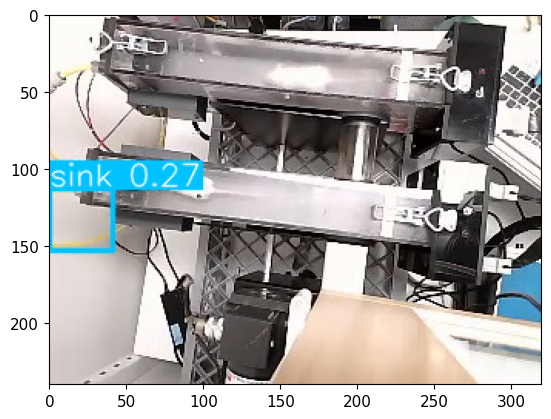

In [10]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

Now that the model is loaded, on to model training

In [9]:
# create dataset.yaml file

In [10]:
!cd yolov5 && python train.py  --img 320 --batch 16 --epochs 100 --data dataset.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.11.4 torch-2.0.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, a

#### Load and apply model

In [14]:
# enter the desired experiment from yolov5/runs/train
# this is telling yolov5 that we want to use a custom model, and then we tell it which weights to use
model_trained = torch.hub.load('ultralytics/yolov5','custom',path='yolov5/runs/train/exp3/weights/best.pt')

Using cache found in /Users/brennanwadsworth/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-17 Python-3.11.4 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


Same code as above, input images to the trained model and see if it can pick out the mouse

In [15]:
IMAGES_PATH = os.path.join('data','val','images')
for roots, dirs, files in os.walk(IMAGES_PATH):
    imgs = files
for roots, dirs, files in os.walk(LABELS_PATH):
    labels = files
img = IMAGES_PATH+'/'+imgs[40]
img
results = model_trained(img)
results.print()

image 1/1: 240x320 3 mouses
Speed: 28.8ms pre-process, 319.0ms inference, 6.8ms NMS per image at shape (1, 3, 480, 640)


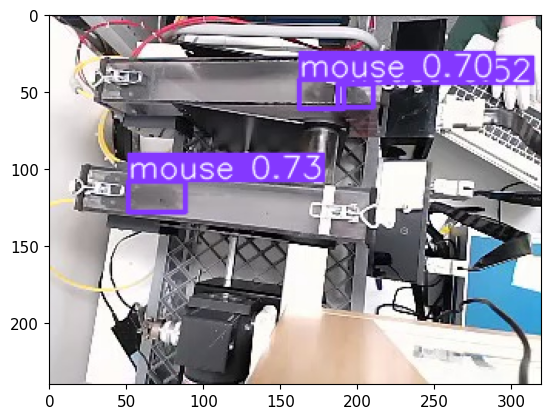

In [16]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

In [17]:
results.pred[0:] #output is x1, y1, x2, y2, confidence, class (15 = mouse, 16 = blue_line)

[tensor([[ 51.91589, 108.83338,  88.49723, 128.14886,   0.73377,  15.00000],
         [162.63550,  42.20646, 191.34100,  61.07940,   0.69519,  15.00000],
         [187.38225,  45.10648, 210.11156,  60.68972,   0.51992,  15.00000]])]

## Detection
#### Idea now is to load a video, read it frame by frame, record the instances of mouse and blue_line, and track their position.


In [18]:
# reproduce model_trained variable
model_trained = torch.hub.load('ultralytics/yolov5','custom',path='yolov5/runs/train/exp3/weights/best.pt')

Using cache found in /Users/brennanwadsworth/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-17 Python-3.11.4 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


In [19]:
os.chdir(ROOT)
VIDEOS_PATH = "/Volumes/RSJ_BW_2024/RSJ_2024/Treadmill_Videos/250319"
RESULTS_PATH = os.path.join('results')
if not os.path.exists(RESULTS_PATH):
    if os.name == 'posix':
        !mkdir -p {RESULTS_PATH}

for roots, dirs, files in os.walk(VIDEOS_PATH):
    videos = files
print(f'{len(videos)} videos for analysis')
for video in videos:
    print(video)
    os.chdir(ROOT)
    vidObj = cv2.VideoCapture(os.path.join(VIDEOS_PATH,video)) # collects video object in cv2 framework
    df = pd.DataFrame(columns=['frame', 'xmin','ymin','xmax','ymax','confidence','class','name'])
    success = True
    count = 0
    while success:
        success, img = vidObj.read() # this will step by step read each frame of the video
        if success and count % 30 == 0:
            results = model_trained(img)
            df = pd.concat([df,results.pandas().xyxy[0].join(pd.Series([count] * results.pandas().xyxy[0].shape[0], name="frame"))],ignore_index=True)
        count += 1
    os.chdir(RESULTS_PATH)
    df.to_csv(f'{video}_tracking_results.csv')


4 videos for analysis
250319_FVB for training model.mp4
._250319_FVB for training model.mp4
WIN_20250217_17_10_54_Pro.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7fe788b3a400] moov atom not found
OpenCV: Couldn't read video stream from file "/Volumes/RSJ_BW_2024/RSJ_2024/Treadmill_Videos/250319/._250319_FVB for training model.mp4"


KeyboardInterrupt: 

In [23]:

!cd yolov5 && python detect.py  --img 320 --data dataset_detect.yaml --weights runs/train/exp3/weights/best.pt --save-txt --save-conf --vid-stride 30
# videos were captured in 30 frames per second
# this code shows that it is possible to give yolov5 a video and it will already conduct the detections for each frame within the vide.
# this code will also create a new video showing the model-detected bounding boxes, so nice to have! 
# this bash line call saves each detection to a text file instead of a variable that we can use here, so best to create a new code line here

detect: weights=['runs/train/exp3/weights/best.pt'], source=data/images, data=dataset_detect.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=30
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.11.4 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
image 1/4 /Volumes/RSJ_BW_2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision/yolov5/data/images/bus.jpg: 320x256 (no detections), 141.1ms
image 2/4 /Volumes/RSJ_BW_2024/RSJ_2024/YOLOV5_TreadmillVision/Mouse_Treadmill_Computer_Vision/yolov5/data/images/zidane.jpg: 192x320 (no detections), 67.8ms
video 3/4 (1/2974) /Volumes/RSJ_BW_20